<a href="https://colab.research.google.com/github/ffelicioni/conv3d_video/blob/main/clasificar_hands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Módulos

In [1]:
import os as os
import pandas as pd
import glob
from pathlib import Path

from IPython.display import clear_output
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as math

from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras

import cv2

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from skimage import io

import random as random

import shutil

## Funciones

In [2]:
! mkdir /content/src
sys.path.append('./src')
% cd /content/src
archivos=['__init__.py','armado_dataset.py','clasificacion.py','visualizar_filtros.py','carga_datos.py']
for archivo in archivos:
    !wget "https://raw.githubusercontent.com/ffelicioni/conv3d_video/main/src/{archivo}"
% cd /content

clear_output()

In [4]:
from armado_dataset import video_capturing_function, data_load_function_frames, resampling_rand, data_load_frames_save_tf, load_data_from_tf

from clasificacion import prob2labels, accuracy, confusion

from visualizar_filtros import plot_conv_weight, layer_by_name

In [5]:
class CustomSequence(keras.utils.Sequence):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.n=3840
    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, batch_index):
        idx_start = batch_index*self.batch_size
        idx_end = idx_start+self.batch_size
        
        X=load_data_from_tf(df_train_batch[idx_start:idx_end],"train_data")
        a=np.array(df_train_batch[idx_start:idx_end].ID)
        y = tf.keras.utils.to_categorical(a-1, num_classes =64)
        
        nf,w,h=X[0].shape
        X.reshape(self.batch_size,nf,w,h,1)
        return X, y

## Chequeo GPU

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!/opt/bin/nvidia-smi

Mon Jul  4 20:07:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import gc
gc.collect()

297

## Datasets

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip drive/MyDrive/lsa64_preprocessed.zip -d dataset
clear_output()

Armo dataset con nombres de los videos disponibles

In [11]:
import glob
from pathlib import Path
import pandas as pd
meta=[]
data = []
for file_path in sorted(glob.glob('/content/dataset/lsa64_hand_videos/*.avi')):
  filename = Path(file_path).stem
  filename_parts = filename.split('_')
  metadata = {'file_path': file_path,
              'ID': filename_parts[0],
              'persona': filename_parts[1],
              'repeticion': filename_parts[2],
              'mano': filename_parts[3]
              }
  meta.append(metadata)
  #image = io.cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
  #data.append(image)

df = pd.DataFrame(meta)
df.ID=df.ID.astype('int64')

In [12]:
print('cantidad de videos:',len(sorted(glob.glob('/content/dataset/lsa64_hand_videos/*.avi'))))
print('cantidad de personas:', len(df.persona.unique()))
print('cantidad de repeticiones:', len(df.repeticion.unique()))

cantidad de videos: 4299
cantidad de personas: 10
cantidad de repeticiones: 5


In [13]:
clases=pd.read_csv('/content/drive/MyDrive/clase_LSA64.csv')
print('cantidad de clases:', len(clases.Name.unique()),'nombres: ',clases.Name.unique())

cantidad de clases: 63 nombres:  ['Opaque' 'Red' 'Green' 'Yellow' 'Bright' 'Light-blue' 'Colors' 'Women'
 'Enemy' 'Son' 'Man' 'Away' 'Drawer' 'Born' 'Learn' 'Call' 'Skimmer'
 'Bitter' 'Sweet milk' 'Milk' 'Water' 'Food' 'Argentina' 'Uruguay'
 'Country' 'Last name' 'Where' 'Mock' 'Birthday' 'Breakfast' 'Photo'
 'Hungry' 'Map' 'Coin' 'Music' 'Ship' 'None' 'Name' 'Patience' 'Perfume'
 'Deaf' 'Trap' 'Rice' 'Barbecue' 'Candy' 'Chewing-gum' 'Spaghetti'
 'Yogurt' 'Accept' 'Thanks' 'Shut down' 'Appear' 'To land' 'Catch' 'Help'
 'Dance' 'Bathe' 'Buy' 'Copy' 'Run' 'Realize' 'Give' 'Find']


hay 63 clases distintas porque la clase "Red" se repite. 

In [14]:
df['id_name']=pd.merge(df,clases,on='ID',how='left').Name
df

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_001...,1,001,001,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_001_003...,1,001,003,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_001_004...,1,001,004,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
...,...,...,...,...,...,...
4294,/content/dataset/lsa64_hand_videos/064_010_001...,64,010,001,right,Find
4295,/content/dataset/lsa64_hand_videos/064_010_002...,64,010,002,right,Find
4296,/content/dataset/lsa64_hand_videos/064_010_003...,64,010,003,right,Find
4297,/content/dataset/lsa64_hand_videos/064_010_004...,64,010,004,right,Find


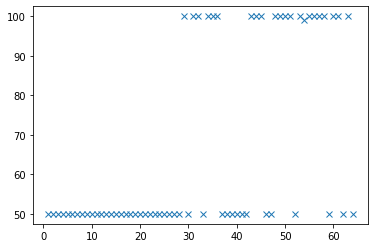

In [15]:
plt.plot(df.ID.value_counts(),'x')

Lotes de 4

In [16]:
batch=960
batch_size=4
cant_train=batch*batch_size #6*
n_test=len(df)-cant_train
print('entrenamiento:',cant_train, 'testing:', n_test,'-', (len(df)-cant_train)/cant_train,'%')
print('cantidad batch:',batch,'batch_size:', cant_train / batch)

entrenamiento: 3840 testing: 459 - 0.11953125 %
cantidad batch: 960 batch_size: 4.0


In [17]:
X_train_index, X_test_index, y_train, y_test = train_test_split(df.index, df.ID, stratify=df.ID, test_size=n_test,random_state=0)

df_train=df.loc[sorted(X_train_index)]

df_test=df.loc[sorted(X_test_index)]
df_test

,file_path,ID,persona,repeticion,mano,id_name
10,/content/dataset/lsa64_hand_videos/001_003_001...,1,003,001,right,Opaque
11,/content/dataset/lsa64_hand_videos/001_003_002...,1,003,002,right,Opaque
23,/content/dataset/lsa64_hand_videos/001_005_004...,1,005,004,right,Opaque
31,/content/dataset/lsa64_hand_videos/001_007_002...,1,007,002,right,Opaque
32,/content/dataset/lsa64_hand_videos/001_007_003...,1,007,003,right,Opaque
...,...,...,...,...,...,...
4254,/content/dataset/lsa64_hand_videos/064_002_001...,64,002,001,right,Find
4256,/content/dataset/lsa64_hand_videos/064_002_003...,64,002,003,right,Find
4258,/content/dataset/lsa64_hand_videos/064_002_005...,64,002,005,right,Find
4269,/content/dataset/lsa64_hand_videos/064_005_001...,64,005,001,right,Find


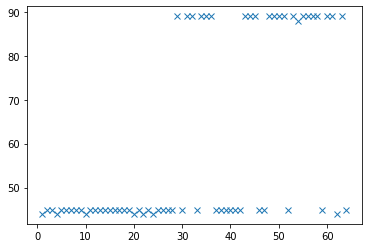

In [18]:
plt.plot(df_train.ID.value_counts(),'x')

Separo en conjuntos de acuerdo a clase (intento que haya algún video de cada clase). 

In [19]:
df_resto=df_train.copy()
df_train_batch=pd.DataFrame([])
for i in range(batch-1):
  X_train_index, X_test_index, y_train, y_test = train_test_split(df_resto.index, df_resto.ID, test_size=cant_train//batch,random_state=0)
  df_seleccion=df_resto.loc[sorted(X_test_index)]   #dataset seleccionado de x videos
  df_resto=df_resto.loc[sorted(X_train_index)]      #sigue iterando en el resto  
  df_train_batch=pd.concat([df_train_batch,df_seleccion],axis=0)    #ordeno el dataset_batch
  

df_train_batch=pd.concat([df_train_batch,df_resto],axis=0)    #agrego la ultima parte

In [21]:
df_train_batch[0:4]

,file_path,ID,persona,repeticion,mano,id_name
1516,/content/dataset/lsa64_hand_videos/030_004_002...,30,004,002,right,Birthday
1909,/content/dataset/lsa64_hand_videos/035_001_005...,35,001,005,right,Coin
3993,/content/dataset/lsa64_hand_videos/060_010_003...,60,010,003,left,Copy
4072,/content/dataset/lsa64_hand_videos/061_008_002...,61,008,002,right,Run


In [22]:
%ls

dataset/  drive/  sample_data/  src/


# Data training - test

Con la separación realizada se arman dos carpetas: train_data y test_data. Cada video fue convertido a un conjunto de imágenes de 1 solo canal, dentro de cada archivo

In [23]:
video_capturing_function(df_train,'train_data')

video_capturing_function(df_test,'test_data')

#https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77

All frames written in the: train_data Folder
All frames written in the: test_data Folder


In [24]:
gc.collect()

357

### Ejemplo 
Imagen de uno de los videos

Dimensiones de la imagen:


<Figure size 432x288 with 0 Axes>

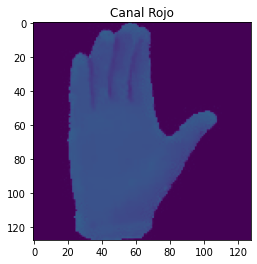

<Figure size 432x288 with 0 Axes>

In [25]:
imagen_rgb=(io.imread("/content/train_data/001_001_001_right/frame0.jpg")/255.0).astype('float32')
plt.imshow(imagen_rgb) # no es necesario el vmin/vmax para imágenes a color

print("Dimensiones de la imagen:")
plt.imshow(imagen_rgb,vmin=0,vmax=1)
plt.title("Canal Rojo")
plt.figure()

### Obtención de tensores 

**Funcion "data_load_frames_save_tf"**

Proceso los videos y selecciono 32 frames del total de videos de forma aleatoria, en caso que los videos tengan menos frames repito el último hasta completar los 32.

Los frames de cada video (imágenes) se pasan a tensores de numpy para que cuando se desee cargar lotes no se tenga que procesar imagenes sino leer archivos numpy previamente salvados. Los tensores son grabados en float32 para reducir el tamaño de archivos.

La función borra además las imágenes para no sobrecargar el disco de la máqunia del colab.

Los archivos de los tensores de numpy se guardan en **train_data** y **test_data**

In [26]:
data_load_frames_save_tf(df_test,'test_data',32)
data_load_frames_save_tf(df_train,'train_data',32)

In [27]:
gc.collect()

100

# Modelo Convolucional 3D 


In [28]:
test_dataset_new=load_data_from_tf(df_test,"test_data")

In [29]:
#a=np.array(df_train.ID)
#y_train = tf.keras.utils.to_categorical(a-1, num_classes =np.max(df_train.ID))

a=np.array(df_test.ID)
y_test = tf.keras.utils.to_categorical(a-1, num_classes =np.max(df_test.ID))

model_output_size=len(df_test.ID.unique())
model_output_size

64

Conv2D(stride_temporal=2)->
Conv2D(stride_temporal=2,stride_espacial=2) -> Conv2D(stride_temporal=2) -> Conv2D(stride_temporal=2,stride_espacial=2)

In [30]:
nf=32
w=128 
h=128

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3), strides=(1,1,2), padding='same', activation = 'relu', input_shape = (nf,w, h, 1)))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(1,1,2), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 64, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu')) 
    
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))
    model.add(GlobalAveragePooling3D())
    #model.add(Dense(64, activation = 'relu'))
    #model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 128, 64, 32)   896       
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 64, 32, 32)    27680     
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 64, 16, 32)    27680     
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 32, 8, 64)      55360     
                                                                 
 batch_normalization (BatchN  (None, 8, 32, 8, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 16, 4, 64)     0         
 )                                                      

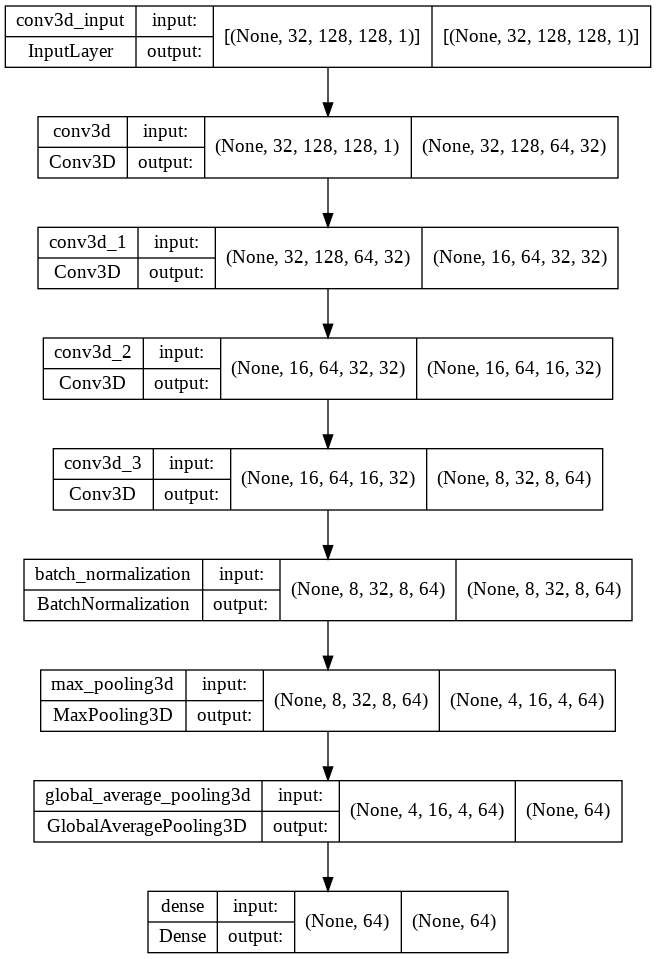

In [31]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Entrenamiento con Custom Sequence 

La función CustomSequence carga cada lote con 128 tensores numpy guardados en la carpeta train_data (nombre de archivo.npy) usando la función 
**load_data_from_tf**. 

In [32]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# generator
#model_training_history = model.fit(generator(64), steps_per_epoch=60 , #validation_data=(test_dataset_new,y_test),
#                                   callbacks = [early_stopping_callback]) #, shuffle = True
# entrenamiento clásico
#model_training_history = model.fit(x = train_dataset_new, y = y_train, epochs = 50, batch_size = 10 , validation_data=(test_dataset_new,y_test), callbacks = [early_stopping_callback]) #, shuffle = True

# usando generador custom
model_training_history = model.fit_generator(CustomSequence(4), epochs=1 , validation_data=(test_dataset_new,y_test), callbacks = [early_stopping_callback]) #, shuffle = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


960/960 [==============================] - 71s 61ms/step - loss: 3.9049 - accuracy: 0.0385 - val_loss: 3.7844 - val_accuracy: 0.0414


In [47]:
import pickle
print("Saving trained model..")
model.save("conv3d_lsa64")
print("Saving preprocessing function...")
with open("preprocess_function.pickle", "wb") as f:
    f.write(pickle.dumps(preprocess_data))
print("Done.")

Saving trained model..
INFO:tensorflow:Assets written to: conv3d_lsa64/assets
Saving preprocessing function...


NameError: ignored

In [33]:
y_predict=model.predict(test_dataset_new)

In [34]:
y_pred=prob2labels(y_predict)

In [35]:
accuracy(np.array(df_test.ID)-1,y_pred)

0.04139433551198257

In [36]:
confusion_calculada=confusion(np.array(df_test.ID)-1,y_pred).astype(int)
names=df.id_name.unique()
pd.DataFrame(confusion_calculada)#, index=names, columns=names)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0


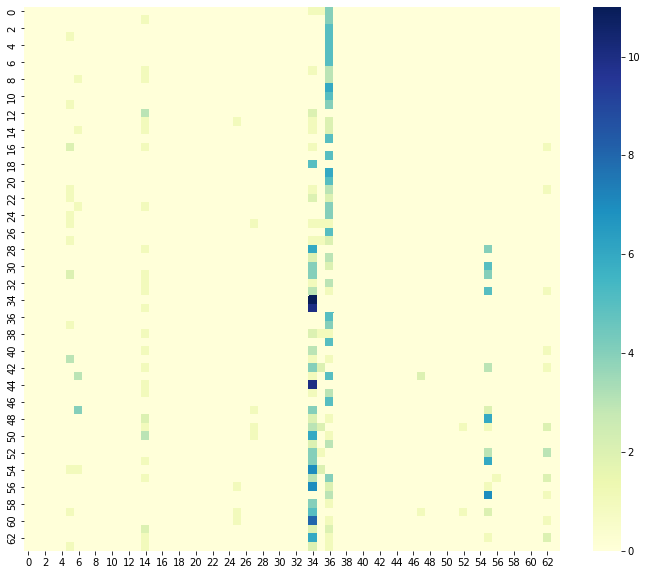

In [37]:
plt.figure(figsize=(12,10))
import seaborn as sns
sns.heatmap(confusion_calculada, cmap="YlGnBu") #,annot=True

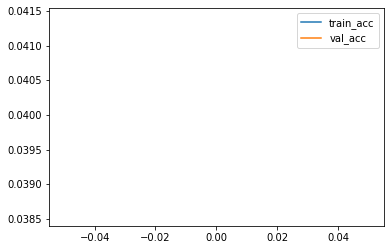

In [38]:
plt.plot(model_training_history.history['accuracy'])
plt.plot(model_training_history.history['val_accuracy'])
plt.legend(['train_acc','val_acc'])

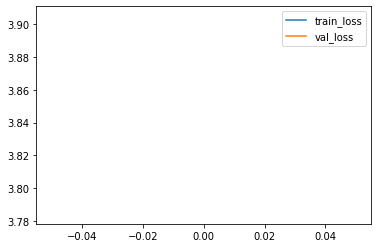

In [39]:
plt.plot(model_training_history.history['loss'])
plt.plot(model_training_history.history['val_loss'])
plt.legend(['train_loss','val_loss'])

Tengo 63 nombres y 64 IDs, se repite  "Red"

In [40]:
for layer in model.layers:
    if 'conv'  in layer.name.lower():
      filters, biases = layer.get_weights()
      print(layer.name,filters.shape)
    else:
      weights = layer.get_weights()
      if len(weights)>0:
        message = ",".join([str(w.shape) for w in weights])
      else:
        message="none"
      print(f"{layer.name} weights: {message}")


conv3d (3, 3, 3, 1, 32)
conv3d_1 (3, 3, 3, 32, 32)
conv3d_2 (3, 3, 3, 32, 32)
conv3d_3 (3, 3, 3, 32, 64)
batch_normalization weights: (64,),(64,),(64,),(64,)
max_pooling3d weights: none
global_average_pooling3d weights: none
dense weights: (64, 64),(64,)


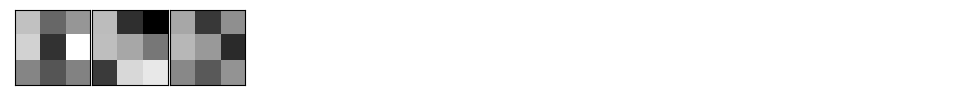

In [41]:
#Elegir capa convolucional y nro de filtro
layer_name="conv3d_1"#"block1_conv2"
filter_index=0
#dibujar filtro
layer = layer_by_name(model,layer_name)
filters, biases = layer.get_weights()
plot_conv_weight(layer.name,filters[:,:,:,filter_index,0])

In [42]:
filters.shape

(3, 3, 3, 32, 32)

In [44]:
#stride(2,1,1) #primera capa
#keras.layers.InputLayer(input_shape=[32,32,3]), para separar de la primera cada de convolucion

# Plot generated samples
#rows,cols = 5,5
#f,ax=plt.subplots(rows,cols,figsize=(rows*1.5,cols*1.5))
#for i in range(rows):
  #for j in range(cols):
	
    #x = samples_iterator.next()
    #image = x[0].astype('uint8')
    #ax[i,j].imshow(image)

#print("Saving trained model..")
#model.save("conv_cifar10")
#print("Saving preprocessing function...")
#with open("preprocess_function.pickle", "wb") as f:
#    f.write(pickle.dumps(preprocess_data))
#print("Done.")
#del model # delete variable, release memory